In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [3]:
amazon_model = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
amazon_model.summary()

W1206 04:13:24.434199 139855838942976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1206 04:13:24.440888 139855838942976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1206 04:13:24.460076 139855838942976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1206 04:13:24.460542 139855838942976 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1206 04:13:24.460957 139855838

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [8]:
layer_names = ['concatenate_1', 'concatenate_2', 'concatenate_3']
layer_outputs = [amazon_model.get_layer(k).output for k in layer_names]
layer_outputs

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 75, 75, 96) dtype=float32>,
 <tf.Tensor 'concatenate_2/concat:0' shape=(?, 37, 37, 224) dtype=float32>,
 <tf.Tensor 'concatenate_3/concat:0' shape=(?, 18, 18, 736) dtype=float32>]

In [12]:
amazon_pretrain_model = Model(amazon_model.input, layer_outputs)
for layer in amazon_pretrain_model.layers:
    layer.trainable = False
amazon_pretrain_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [20]:
input_model = Input(shape=(300,300,3))

concat_1, concat_2, concat_3 = amazon_pretrain_model(input_model)

gap_1 = GlobalAveragePooling2D()(concat_1)
gap_2 = GlobalAveragePooling2D()(concat_2)
gap_3 = GlobalAveragePooling2D()(concat_3)

gap = concatenate([gap_1, gap_2, gap_3])

x = Dropout(0.5)(gap)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

tf_model = Model(input_model, x)
tf_model.compile(loss=categorical_crossentropy, optimizer=Adam(0.0005), metrics=['accuracy'])
tf_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 75, 75, 96), 6233504     input_4[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 96)           0           model_4[3][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_8 (Glo (None, 224)          0           model_4[3][1]                    
__________________________________________________________________________________________________
global_ave

In [31]:
for i in range(-2,0):
    tf_model.layers[i].set_weights(amazon_model.layers[i].get_weights())

In [29]:
tf_model.layers[-3].output_shape

(None, 31)

In [3]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [18]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/tf_gap_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = tf_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/tf_gap_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/60
13/13 [==============================] - 6s 455ms/step - loss: 3.7740 - acc: 0.0433 - val_loss: 3.3560 - val_acc: 0.0417
Epoch 2/60
13/13 [==============================] - 3s 235ms/step - loss: 3.4520 - acc: 0.0906 - val_loss: 3.2847 - val_acc: 0.1250
Epoch 3/60
13/13 [==============================] - 2s 136ms/step - loss: 3.2761 - acc: 0.1065 - val_loss: 2.9496 - val_acc: 0.1750
Epoch 4/60
13/13 [==============================] - 3s 206ms/step - loss: 3.0563 - acc: 0.1357 - val_loss: 2.9397 - val_acc: 0.2375
Epoch 5/60
13/13 [==============================] - 3s 234ms/step - loss: 2.9208 - acc: 0.1910 - val_loss: 2.8782 - val_acc: 0.2396
Epoch 6/60
13/13 [==============================] - 3s 217ms/step - loss: 2.6902 - acc: 0.2232 - val_loss: 2.9793 - val_acc: 0.2375
Epoch 7/60
13/13 [==============================] - 3s 225ms/step - loss: 2.6097 - acc: 0.2744 - val_loss: 2.6489 - val_acc: 0.3125
Epoch 8/60
13/13 [==============================] - 3s 225ms/step - loss: 2.

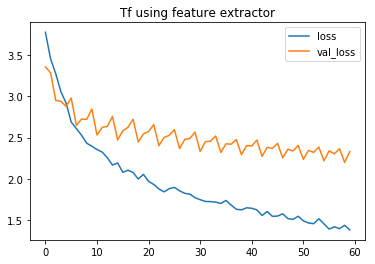

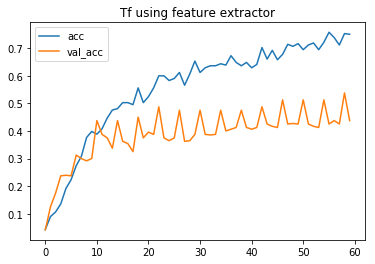

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Tf using feature extractor')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Tf using feature extractor')
plt.legend()
plt.show()

In [33]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/tf_gap_model_2.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = tf_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/tf_gap_history_2.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/60
13/13 [==============================] - 4s 278ms/step - loss: 4.8091 - acc: 0.0385 - val_loss: 3.5281 - val_acc: 0.0938
Epoch 2/60
13/13 [==============================] - 2s 177ms/step - loss: 4.2890 - acc: 0.0662 - val_loss: 3.3457 - val_acc: 0.0875
Epoch 3/60
13/13 [==============================] - 3s 223ms/step - loss: 3.7987 - acc: 0.1260 - val_loss: 3.1541 - val_acc: 0.1250
Epoch 4/60
13/13 [==============================] - 3s 221ms/step - loss: 3.3060 - acc: 0.1793 - val_loss: 2.9573 - val_acc: 0.1750
Epoch 5/60
13/13 [==============================] - 3s 229ms/step - loss: 3.1583 - acc: 0.1835 - val_loss: 2.7153 - val_acc: 0.2292
Epoch 6/60
13/13 [==============================] - 3s 218ms/step - loss: 2.7217 - acc: 0.2486 - val_loss: 2.7816 - val_acc: 0.1500
Epoch 7/60
13/13 [==============================] - 3s 222ms/step - loss: 2.6762 - acc: 0.2569 - val_loss: 2.5435 - val_acc: 0.2375
Epoch 8/60
13/13 [==============================] - 3s 218ms/step - loss: 2.

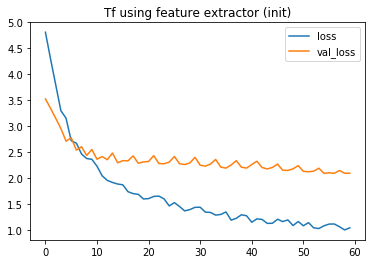

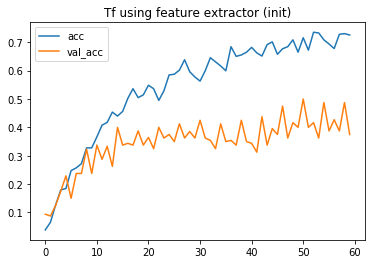

In [34]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Tf using feature extractor (init)')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Tf using feature extractor (init)')
plt.legend()
plt.show()

In [5]:
test_model = load_model('/data/Quan/tf_models/webcam/tf_gap_model_2.hdf5')
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

239/239 [==============================] - 3s 14ms/step


[2.0822312467143127, 0.4100418410041841]

## Fine-tuning model

In [4]:
finetune_model = Model(amazon_model.input, amazon_model.output)
finetune_model.compile(loss=categorical_crossentropy, optimizer=Adam(0.0005), metrics=['accuracy'])
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [5]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/finetune_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = amazon_model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/finetune_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/60
13/13 [==============================] - 11s 812ms/step - loss: 3.0155 - acc: 0.2764 - val_loss: 10.7425 - val_acc: 0.1042
Epoch 2/60
13/13 [==============================] - 9s 658ms/step - loss: 1.4383 - acc: 0.6103 - val_loss: 5.7229 - val_acc: 0.1625
Epoch 3/60
13/13 [==============================] - 5s 368ms/step - loss: 1.0224 - acc: 0.7226 - val_loss: 1.2746 - val_acc: 0.6875
Epoch 4/60
13/13 [==============================] - 5s 369ms/step - loss: 0.8285 - acc: 0.7785 - val_loss: 2.9366 - val_acc: 0.4250
Epoch 5/60
13/13 [==============================] - 5s 374ms/step - loss: 0.6393 - acc: 0.8331 - val_loss: 1.2331 - val_acc: 0.6875
Epoch 6/60
13/13 [==============================] - 5s 369ms/step - loss: 0.5222 - acc: 0.8850 - val_loss: 1.0373 - val_acc: 0.6875
Epoch 7/60
13/13 [==============================] - 5s 369ms/step - loss: 0.4471 - acc: 0.8956 - val_loss: 1.1306 - val_acc: 0.6875
Epoch 8/60
13/13 [==============================] - 5s 369ms/step - loss: 

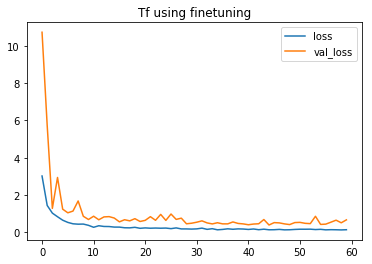

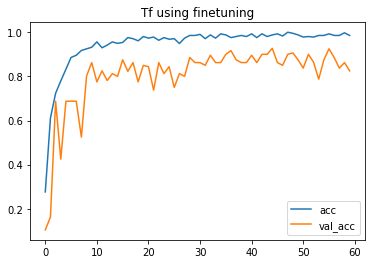

In [6]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Tf using finetuning')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Tf using finetuning')
plt.legend()
plt.show()

In [7]:
test_model = load_model('/data/Quan/tf_models/webcam/finetune_model.hdf5')
score = test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)
score

239/239 [==============================] - 3s 11ms/step


[0.5074861611369422, 0.8744769874476988]